# Build some toy models and how to sample them

In [1]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

# import lightning trainer
import lightning as L
from lightning.pytorch.loggers import WandbLogger

# imports
from jepa.modules import JEA

## Roadmap

- Load a trained model
- Visualize the embedding of a batch of low pT tracks
- Visualize the embedding of a batch of high pT tracks

## Visualize the embedding of a batch of low pT tracks

In [4]:
with open("configs/9_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [15]:
checkpoint_path = "/global/cfs/cdirs/m3443/usr/dtmurnane/Side_Work/Particle-JEPA/notebooks/JEA_toytrack_splittracks/ls5i2t6m/checkpoints/epoch=9-step=1000.ckpt"

# Use lightning load
model = JEA.load_from_checkpoint(checkpoint_path).to("cuda")

# Set the model to also have a larger batch size
model.hparams["batch_size"] = 2000

Batch shapes: x=torch.Size([2000, 20, 4, 2]), mask=torch.Size([2000, 20, 4]), pids=torch.Size([2000, 20]), edge_index=torch.Size([2000, 190, 2]), edge_mask=torch.Size([2000, 190]), y=torch.Size([2000, 190])
Max edge index: 19
Distances shape: torch.Size([380000])
Sample distances: tensor([0.0055, 0.4049, 0.4050, 0.5758, 0.5763], device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


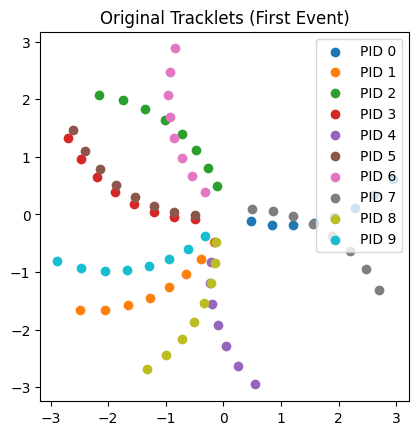

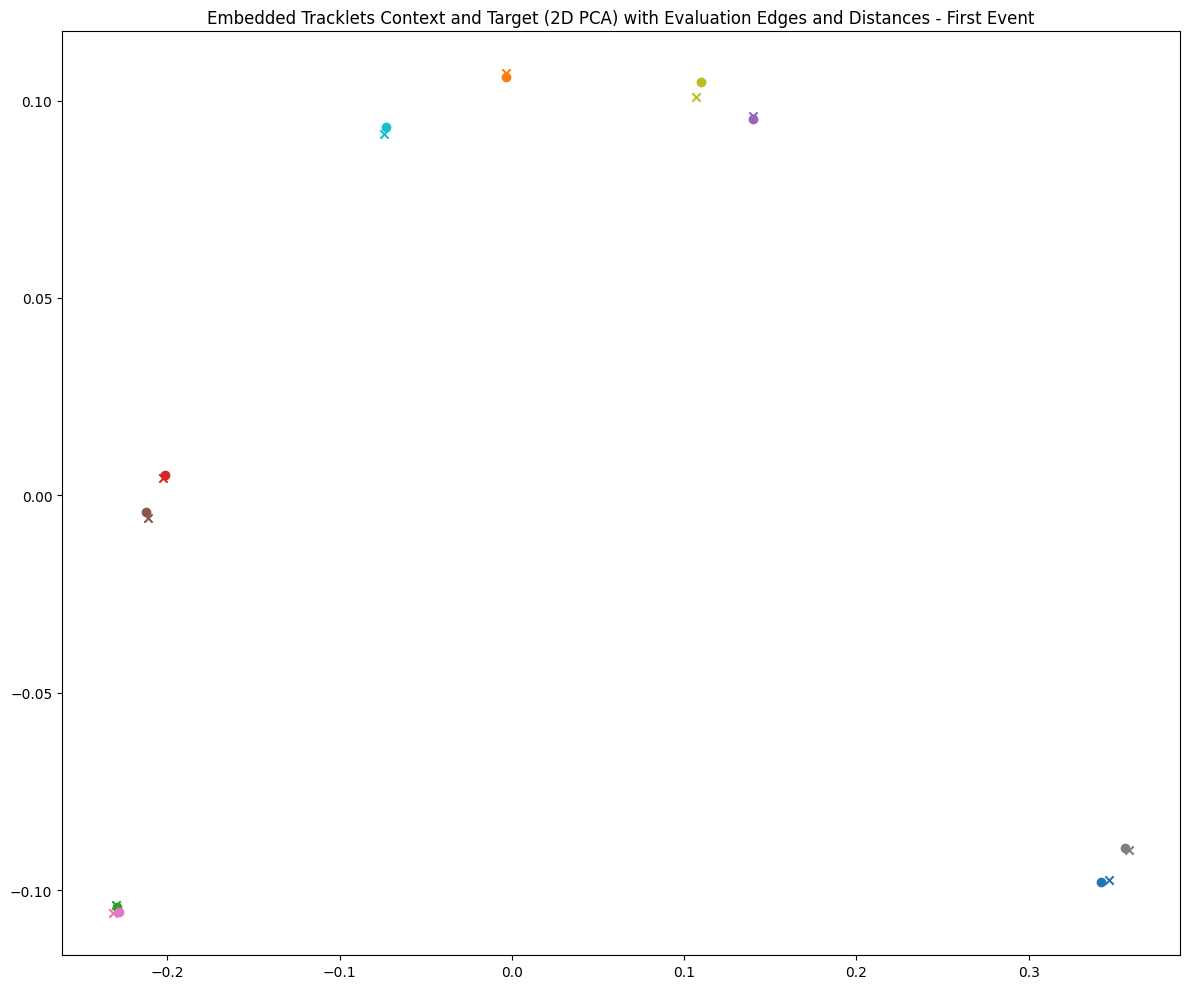

First Batch Metrics:
  Efficiency: 0.9888
  Purity: 0.8223
  Mean True Distance: 0.0029
  Mean Fake Distance: 0.2862


In [16]:
# Make sure the model has low pT tracks
model.hparams["dataset_args"]["particle_guns"][0]["pt"] = [2.5,2.6]

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))

with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
low_pt_embeddings = results["embeddings_0"].cpu().numpy()

Batch shapes: x=torch.Size([2000, 20, 4, 2]), mask=torch.Size([2000, 20, 4]), pids=torch.Size([2000, 20]), edge_index=torch.Size([2000, 190, 2]), edge_mask=torch.Size([2000, 190]), y=torch.Size([2000, 190])
Max edge index: 19
Distances shape: torch.Size([380000])
Sample distances: tensor([0.0080, 0.3354, 0.3302, 0.4691, 0.4700], device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


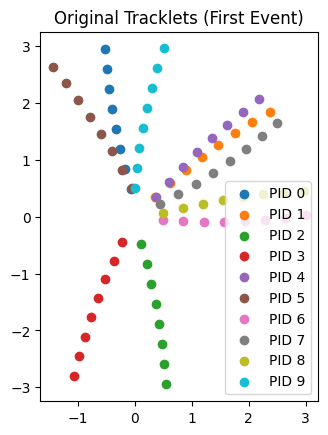

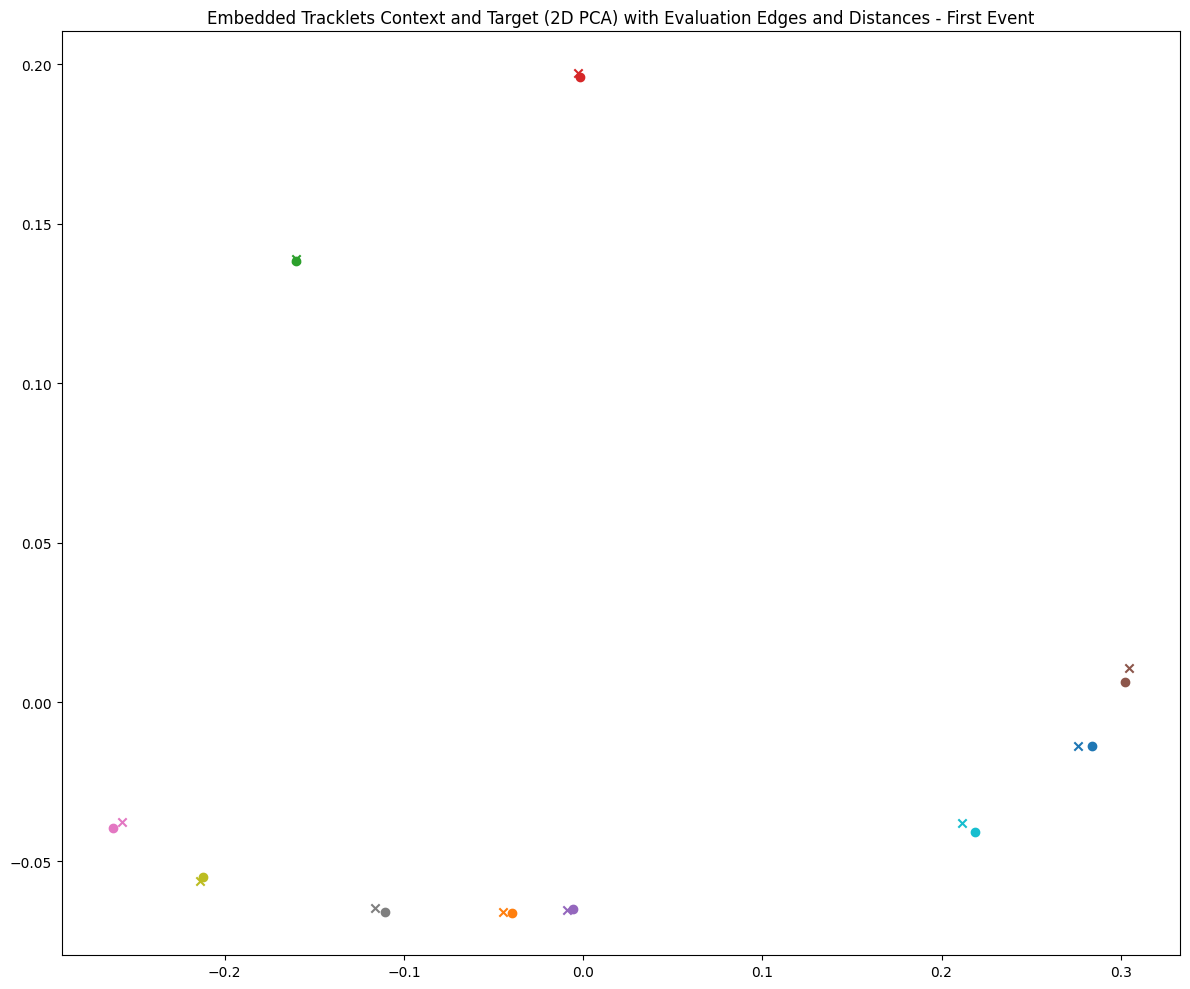

First Batch Metrics:
  Efficiency: 0.9323
  Purity: 0.7846
  Mean True Distance: 0.0056
  Mean Fake Distance: 0.2915


In [17]:
# Now set tracklet pT to be high
model.hparams["dataset_args"]["particle_guns"][0]["pt"] = [10, 11]

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))
with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
high_pt_embeddings = results["embeddings_0"].cpu().numpy()

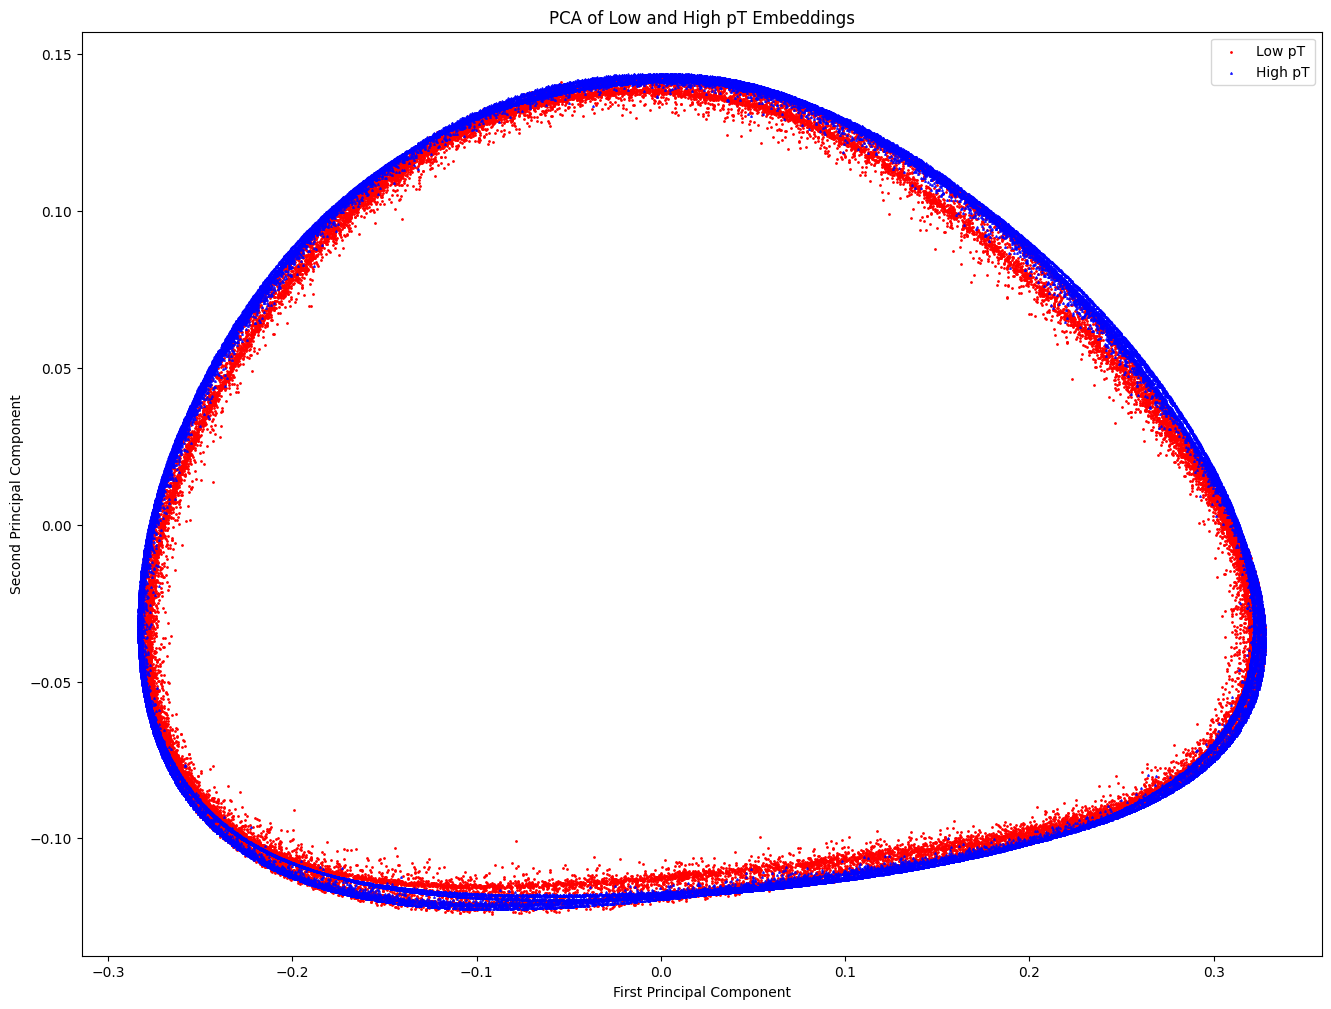

In [19]:
# Plot ALL the embeddings in PCA

from sklearn.decomposition import PCA

# Select embeddings for the first batch entry
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)

# Concatenate low and high pT embeddings for the first batch
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (2*400*20, 8)

# Perform PCA on the concatenated embeddings
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (2*400*20, 2)

# Create a mask for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]  # 400*20
num_high_pt = high_pt_embeddings.shape[0]  # 400*20

low_pt_mask = np.ones(num_low_pt, dtype=bool)       # [True, True, ..., True] (400*20,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)    # [False, False, ..., False] (400*20,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (2*400*20,)

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(
    all_embeddings_pca[pt_mask, 0],
    all_embeddings_pca[pt_mask, 1],
    c="r",
    marker='o',
    label='Low pT',
    s=1
)
plt.scatter(
    all_embeddings_pca[~pt_mask, 0],
    all_embeddings_pca[~pt_mask, 1],
    c="b",
    marker='^',
    label='High pT',
    s=1
)
plt.legend()
plt.title('PCA of Low and High pT Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

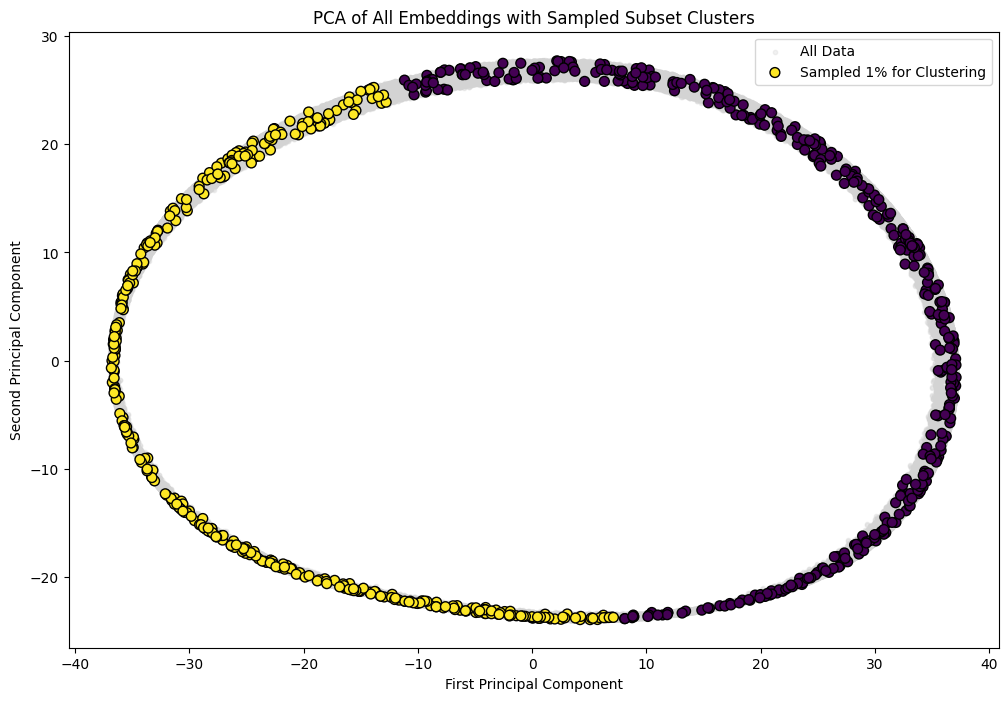

In [13]:
# Plot ALL the embeddings in PCA with Random Sampling for Clustering

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # Example clustering algorithm
from sklearn.model_selection import train_test_split

# ### Step 1: Prepare the Embeddings

# Reshape embeddings to ensure correct dimensions
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)   # Shape: (8000, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8) # Shape: (8000, 8)

# Concatenate low and high pT embeddings
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (16000, 8)

# Perform PCA on all embeddings for visualization
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (16000, 2)

# ### Step 2: Create the pT Mask

# Create boolean masks for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]    # 8000
num_high_pt = high_pt_embeddings.shape[0]  # 8000

low_pt_mask = np.ones(num_low_pt, dtype=bool)      # [True, True, ..., True] (8000,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)   # [False, False, ..., False] (8000,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (16000,)

# ### Step 3: Random Sampling (~1%) with Optional Stratification

# Define the sampling percentage
sampling_percentage = 0.01  # 1%
num_samples = int(sampling_percentage * all_embeddings.shape[0])  # 160 samples

# **Option 1: Simple Random Sampling**
# Uncomment the following lines to use simple random sampling
'''
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(all_embeddings.shape[0], size=num_samples, replace=False)
'''

# **Option 2: Stratified Random Sampling**
# Ensures proportional representation from both low and high pT embeddings
low_pt_indices = np.where(pt_mask)[0]
high_pt_indices = np.where(~pt_mask)[0]

# Calculate number of samples for each group
num_low_samples = int(sampling_percentage * num_low_pt)   # 80 samples
num_high_samples = int(sampling_percentage * num_high_pt) # 80 samples

# Randomly sample from each group
np.random.seed(42)  # For reproducibility
sampled_low_pt = np.random.choice(low_pt_indices, size=num_low_samples, replace=False)
sampled_high_pt = np.random.choice(high_pt_indices, size=num_high_samples, replace=False)

# Combine sampled indices
sample_indices = np.concatenate([sampled_low_pt, sampled_high_pt])  # Shape: (160,)

# ### Step 4: Extract the Sampled Subset

# Extract original embeddings and their PCA projections
subset_embeddings = all_embeddings[sample_indices]        # Shape: (160, 8)
subset_embeddings_pca = all_embeddings_pca[sample_indices]  # Shape: (160, 2)
subset_pt_mask = pt_mask[sample_indices]                  # Shape: (160,)

# ### Step 5: Perform Clustering in Original Embedding Space

# Initialize the clustering algorithm (spectral clustering as an example)
spectral = SpectralClustering(
    n_clusters=2, 
    affinity='nearest_neighbors', 
    assign_labels='discretize',
    n_neighbors=10,
    n_init=1,
    random_state=42,
    n_jobs=-1)
cluster_labels = spectral.fit_predict(subset_embeddings)

# ### Step 6: Visualize the Clustering Results

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c="lightgray",
    marker='o',
    s=10,
    alpha=0.3,
    label='All Data'
)

# Overlay the sampled subset with cluster-based coloring
scatter = plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c=cluster_labels,
    cmap='viridis',
    marker='o',
    s=50,
    edgecolor='k',
    label='Sampled 1% for Clustering'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title('PCA of All Embeddings with Sampled Subset Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()

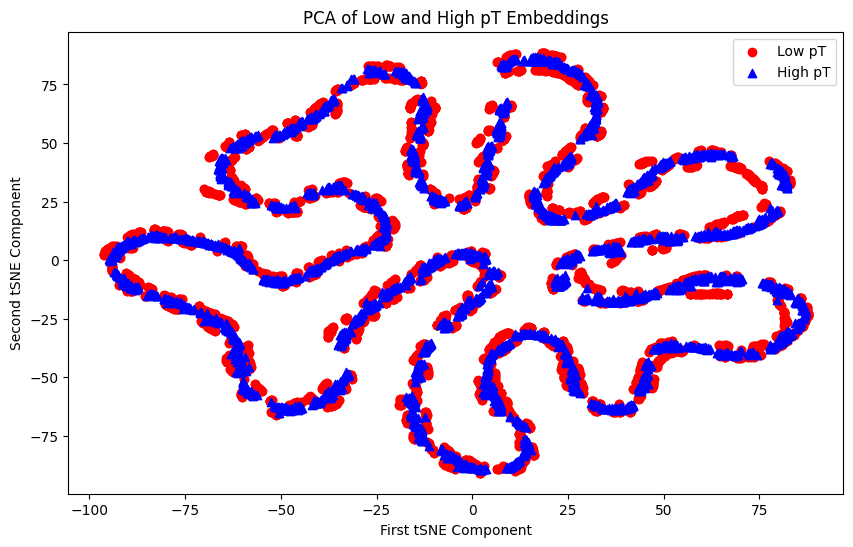

In [8]:
# Plot ALL the embeddings in tSNE

from sklearn.manifold import TSNE

# Select embeddings for the first batch entry
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)

# Concatenate low and high pT embeddings for the first batch
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (2*400*20, 8)

# Perform tSNE on the concatenated embeddings
tsne = TSNE(n_components=2)
all_embeddings_tsne = tsne.fit_transform(all_embeddings)  # Shape: (2*400*20, 2)

# Create a mask for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]  # 400*20
num_high_pt = high_pt_embeddings.shape[0]  # 400*20

low_pt_mask = np.ones(num_low_pt, dtype=bool)       # [True, True, ..., True] (400*20,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)    # [False, False, ..., False] (400*20,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (2*400*20,)

# Plot the tSNE results
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_tsne[pt_mask, 0],
    all_embeddings_tsne[pt_mask, 1],
    c="r",
    marker='o',
    label='Low pT'
)
plt.scatter(
    all_embeddings_tsne[~pt_mask, 0],
    all_embeddings_tsne[~pt_mask, 1],
    c="b",
    marker='^',
    label='High pT'
)
plt.legend()
plt.title('PCA of Low and High pT Embeddings')
plt.xlabel('First tSNE Component')
plt.ylabel('Second tSNE Component')
plt.show()

In [20]:
np.unique(labels, return_counts=True)

(array([-1,  0]), array([  234, 79766]))

In [23]:
# After getting PCA, run DBSCAN in the original space, and color the points by the cluster

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create labels from the mask
all_labels = np.where(pt_mask, 0, 1)  # 0 for low pT (True in pt_mask), 1 for high pT (False in pt_mask)

# Scan through epsilon values from 0.1 to 10, with a step of 1.0
eps_values = np.linspace(0.07, 0.12, 10)
min_samples = 10

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(all_embeddings)
    labels = dbscan.labels_

    # Plot the PCA results, with marker according to pT and color according to cluster
    plt.figure(figsize=(10, 6))
    plt.scatter(
        all_embeddings_pca[:, 0],
        all_embeddings_pca[:, 1],
        c=labels,
        marker='o',
        s=3
    )

    # Get the accuracy, by first matching the labels to the true labels, then taking the mean
    accuracy = np.mean((labels >= 0) == all_labels)
    print(f"Accuracy: {accuracy:.2f}")

    # Plot the confusion matrix
    cm = confusion_matrix(all_labels, labels)
    plt.figure(figsize=(10, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix, eps={eps}')
    plt.show()

    plt.legend()
    plt.title(f'PCA of Low and High pT Embeddings, eps={eps}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

Accuracy: 0.54


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb7b83c1d50>>
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_622902/3730399542.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


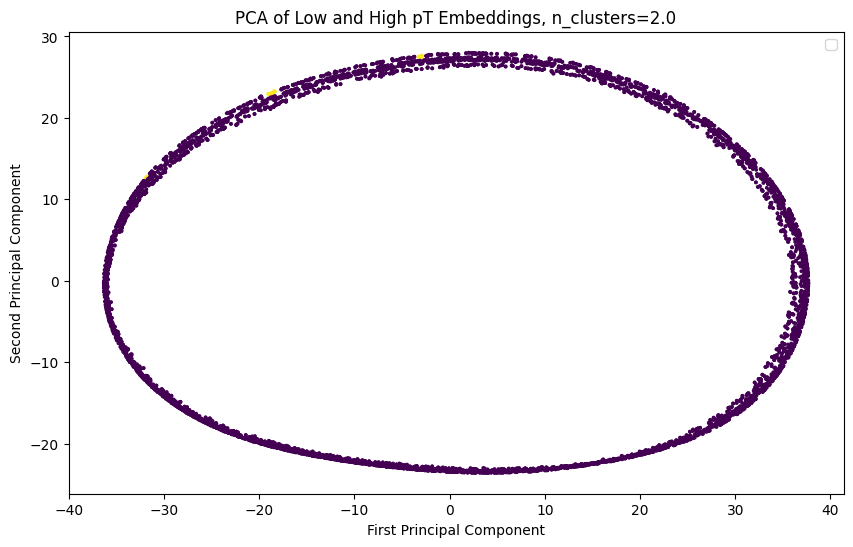

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [44]:
# After getting PCA, run spectral clustering in the original space, and color the points by the cluster

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
n_clusters = np.linspace(2, 10, 10)

for n_clusters in n_clusters:
    spectral = SpectralClustering(n_clusters=int(n_clusters), affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(all_embeddings)

    # Plot the PCA results, with marker according to pT and color according to cluster
    plt.figure(figsize=(10, 6))
    plt.scatter(
        all_embeddings_pca[:, 0],
        all_embeddings_pca[:, 1],
        c=labels,
        marker='o',
        s=3
    )
    plt.legend()
    plt.title(f'PCA of Low and High pT Embeddings, n_clusters={n_clusters}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [14]:
# After getting PCA, run spectral clustering in the original space, and color the points by the cluster

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

spectral = SpectralClustering(
    n_clusters=2, 
    affinity='nearest_neighbors', 
    assign_labels='discretize',
    n_neighbors=10,
    n_init=1,
    random_state=42,
    n_jobs=-1)
labels = spectral.fit_predict(all_embeddings)

# Plot the PCA results, with marker according to pT and color according to cluster
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c=labels,
    marker='o',
    s=3
)
plt.legend()
plt.title(f'PCA of Low and High pT Embeddings, n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# After getting PCA, run spectral clustering in the original space, and color the points by the cluster

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

spectral = SpectralClustering(
    n_clusters=2, 
    affinity='nearest_neighbors', 
    assign_labels='cluster_qr',
    n_neighbors=10,
    n_init=1,
    random_state=42,
    n_jobs=-1)
labels = spectral.fit_predict(all_embeddings)

# Plot the PCA results, with marker according to pT and color according to cluster
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c=labels,
    marker='o',
    s=3
)
plt.legend()
plt.title(f'PCA of Low and High pT Embeddings, n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


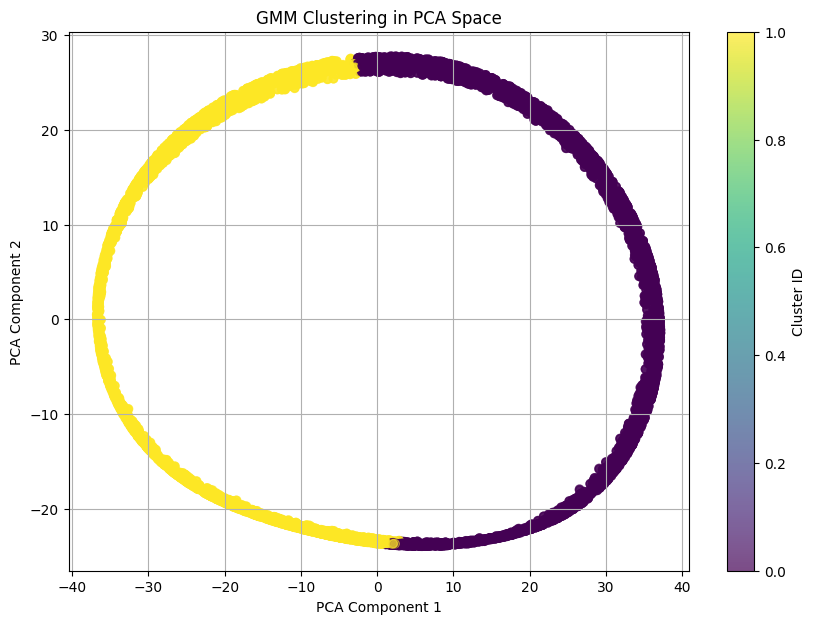

In [10]:
from sklearn.mixture import GaussianMixture

# Fit the Gaussian Mixture Model
n_components = 2  # We expect two clusters: low pT and high pT
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(all_embeddings)

# Step 3: Predict clusters
predicted_labels = gmm.predict(all_embeddings)

# Visualize the GMM results in PCA space
def visualize_gmm_in_pca(pca_embeddings, predicted_labels, title='GMM Clustering in PCA Space'):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        pca_embeddings[:, 0],
        pca_embeddings[:, 1],
        c=predicted_labels,
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Cluster ID')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid()
    plt.show()

# Visualize the GMM results in PCA space
visualize_gmm_in_pca(all_embeddings_pca, predicted_labels)

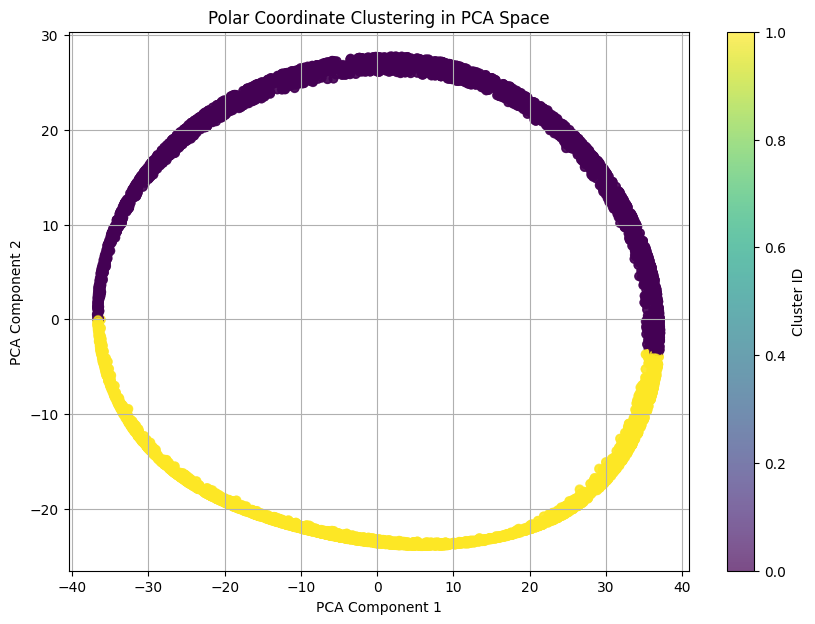

Cluster centers (in degrees): [[ 84.85168]
 [-96.13829]]


In [11]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convert PCA coordinates to polar coordinates
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

# Apply the transformation
r, theta = cartesian_to_polar(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1])

# Cluster using the angle (theta)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(theta.reshape(-1, 1))

# Visualize the results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster ID')
plt.title('Polar Coordinate Clustering in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Print cluster centers in degrees
cluster_centers_degrees = np.degrees(kmeans.cluster_centers_)
print("Cluster centers (in degrees):", cluster_centers_degrees)

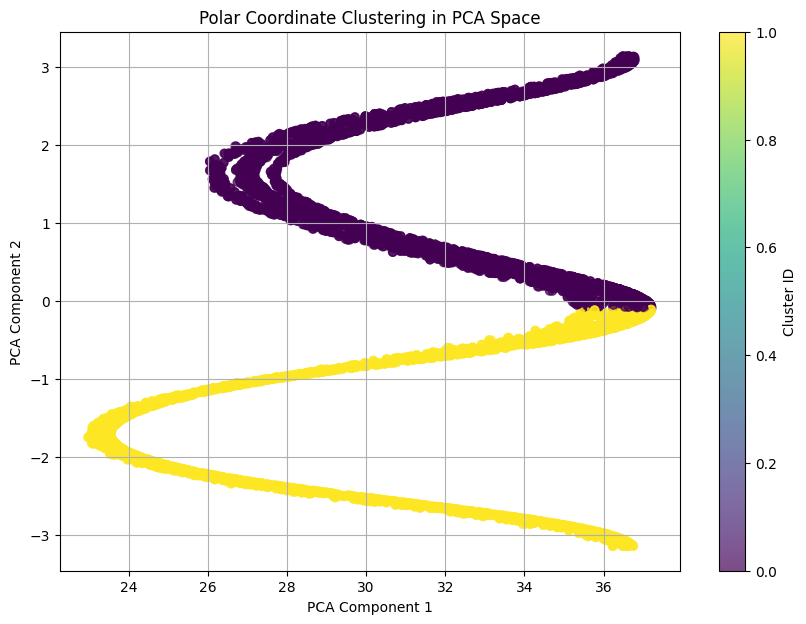

Cluster centers (in degrees): [[ 84.85167 ]
 [-96.138275]]


In [12]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convert PCA coordinates to polar coordinates
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

# Apply the transformation
r, theta = cartesian_to_polar(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1])

# Cluster using the angle (theta)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(theta.reshape(-1, 1))

# Visualize the results, in the polar coordinate space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    r,
    theta,
    c=cluster_labels,
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster ID')
plt.title('Polar Coordinate Clustering in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Print cluster centers in degrees
cluster_centers_degrees = np.degrees(kmeans.cluster_centers_)
print("Cluster centers (in degrees):", cluster_centers_degrees)

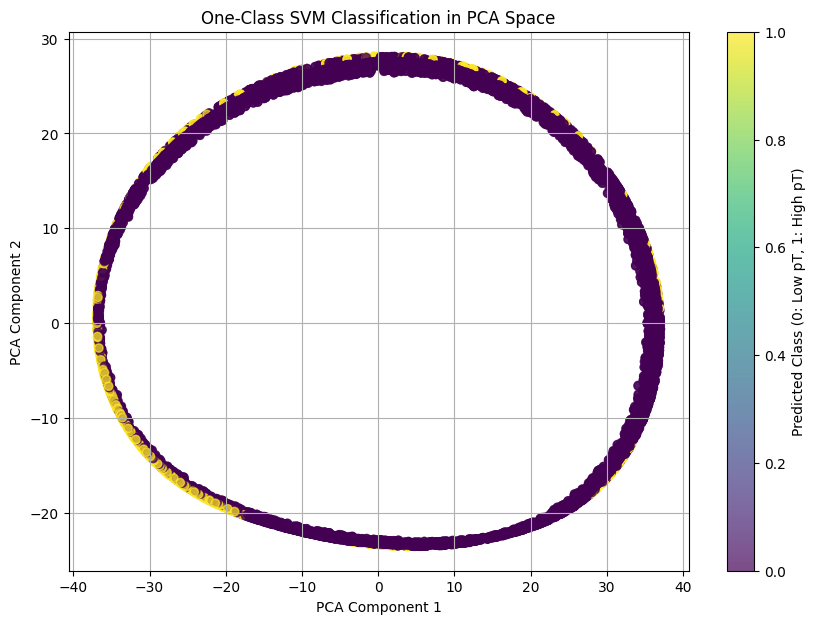

Accuracy: 0.49
True Positive Rate: 0.09
False Positive Rate: 0.10


In [9]:
from sklearn.svm import OneClassSVM
import numpy as np
import matplotlib.pyplot as plt

# Create labels from the mask
all_labels = np.where(pt_mask, 0, 1)  # 0 for low pT (True in pt_mask), 1 for high pT (False in pt_mask)

# Train One-Class SVM on low pT data, in the original space
low_pt_data = all_embeddings[pt_mask]
svm = OneClassSVM(kernel='rbf', nu=0.1)  # nu is the upper bound on the fraction of training errors
svm.fit(low_pt_data)

# Predict on all data
predictions = svm.predict(all_embeddings)

# In One-Class SVM, -1 indicates an outlier (anomaly), and 1 indicates an inlier
# Let's convert this to 0 for low pT (inlier) and 1 for high pT (outlier)
predictions = (predictions == -1).astype(int)

# Visualize the results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c=predictions,
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Predicted Class (0: Low pT, 1: High pT)')
plt.title('One-Class SVM Classification in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Calculate accuracy
accuracy = np.mean(predictions == all_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate true positive rate (TPR) and false positive rate (FPR)
tpr = np.sum((predictions == 1) & (all_labels == 1)) / np.sum(all_labels == 1)
fpr = np.sum((predictions == 1) & (all_labels == 0)) / np.sum(all_labels == 0)
print(f"True Positive Rate: {tpr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")

In [40]:
predictions

array([ 21,  21,  -1, ..., 156,   4,   4])

In [41]:
all_labels

array([0, 0, 0, ..., 1, 1, 1])

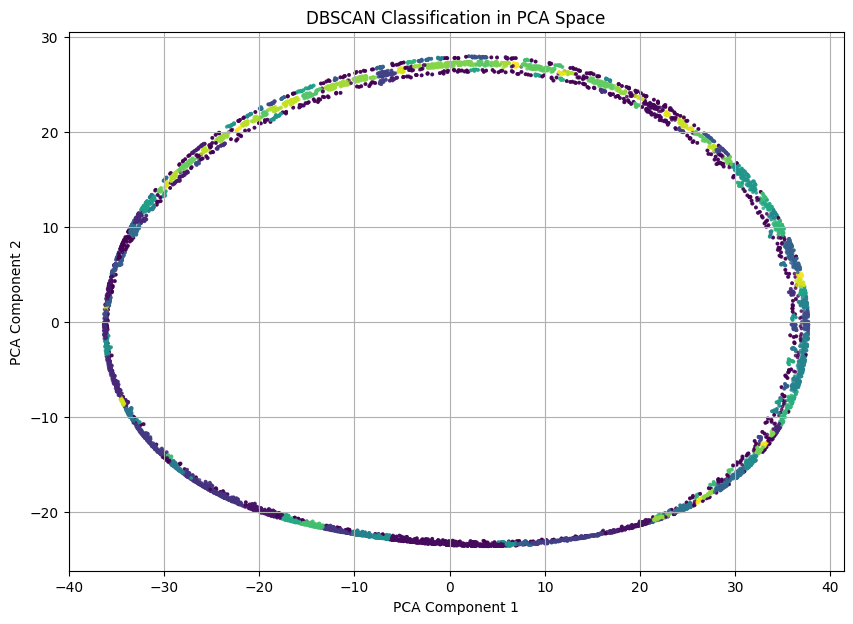

Accuracy: 0.62
True Positive Rate: 0.00
False Positive Rate: 0.00


In [42]:
# Create labels from the mask
all_labels = np.where(pt_mask, 0, 1)  # 0 for low pT (True in pt_mask), 1 for high pT (False in pt_mask)

# Fit DBSCAN with eps=0.75, in the original space
dbscan = DBSCAN(eps=0.35, min_samples=10)
dbscan.fit(all_embeddings)

# Predict on all data
predictions = dbscan.labels_

# Visualize the results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c=predictions,
    alpha=0.7,
    s=3
)
plt.title('DBSCAN Classification in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Calculate accuracy
accuracy = np.mean((predictions >= 0) == all_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate true positive rate (TPR) and false positive rate (FPR)
tpr = np.sum((predictions == 1) & (all_labels == 1)) / np.sum(all_labels == 1)
fpr = np.sum((predictions == 1) & (all_labels == 0)) / np.sum(all_labels == 0)
print(f"True Positive Rate: {tpr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")

In [26]:
all_embeddings.shape

(8000, 8)

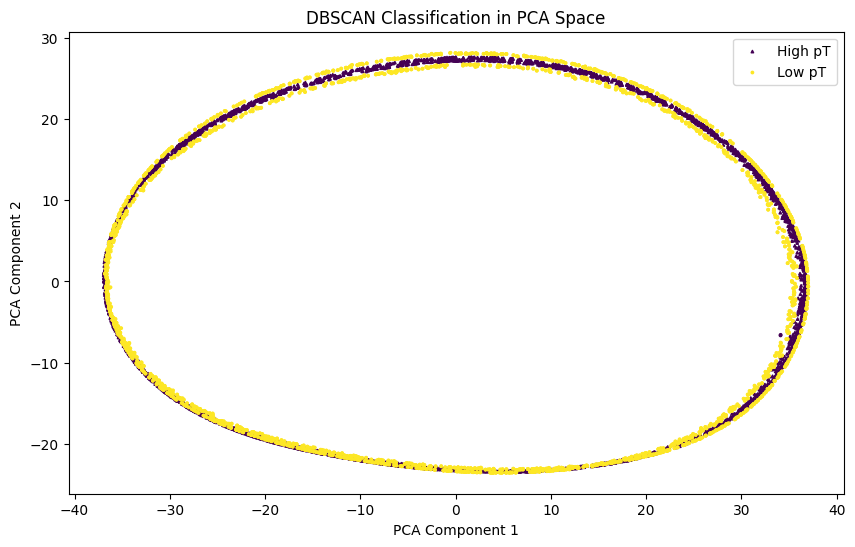

In [25]:
# Create labels from the mask
all_labels = np.where(pt_mask, 0, 1)  # 0 for low pT (True in pt_mask), 1 for high pT (False in pt_mask)

# Fit DBSCAN with eps=0.75, in the original space
dbscan = DBSCAN(eps=0.75, min_samples=10)
dbscan.fit(all_embeddings)

# labels on all data
labels = dbscan.labels_

# Plot the PCA results, with marker according to pT and color according to cluster
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[~pt_mask, 0],
    all_embeddings_pca[~pt_mask, 1],
    c=labels[~pt_mask],
    marker='^',
    label='High pT',
    s=3
)
plt.scatter(
    all_embeddings_pca[pt_mask, 0],
    all_embeddings_pca[pt_mask, 1],
    c=labels[pt_mask],
    marker='o',
    label='Low pT',
    s=3
)

plt.legend()
plt.title('DBSCAN Classification in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

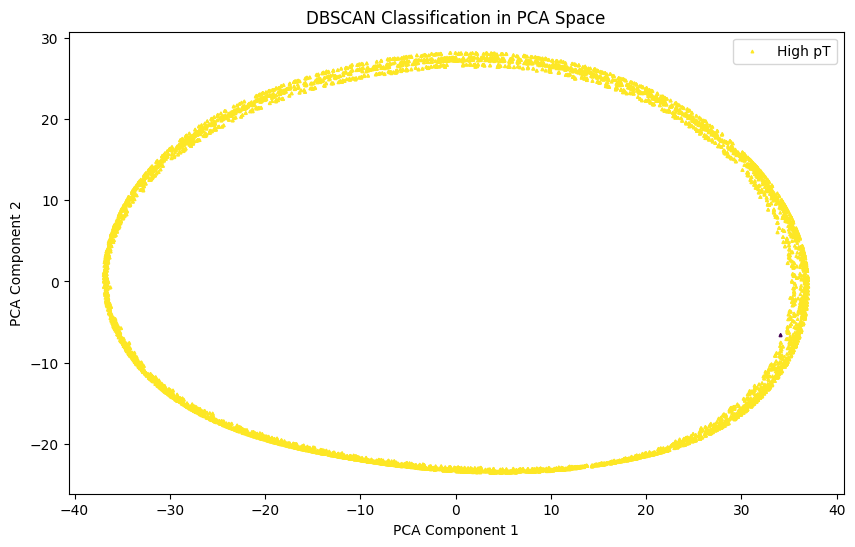

In [27]:
# Create labels from the mask
all_labels = np.where(pt_mask, 0, 1)  # 0 for low pT (True in pt_mask), 1 for high pT (False in pt_mask)

# Fit DBSCAN with eps=0.75, in the original space
dbscan = DBSCAN(eps=0.75, min_samples=10)
dbscan.fit(all_embeddings)

# labels on all data
labels = dbscan.labels_

# Plot the PCA results, with marker according to pT and color according to cluster
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c=labels,
    marker='^',
    label='High pT',
    s=3
)

plt.legend()
plt.title('DBSCAN Classification in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
labels[# Create labels from the mask
all_labels = np.where(pt_mask, 0, 1)  # 0 for low pT (True in pt_mask), 1 for high pT (False in pt_mask)

# Fit DBSCAN with eps=0.75, in the original space
dbscan = DBSCAN(eps=0.75, min_samples=10)
dbscan.fit(all_embeddings)

# labels on all data
labels = dbscan.labels_

# Plot the PCA results, with marker according to pT and color according to cluster
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[~pt_mask, 0],
    all_embeddings_pca[~pt_mask, 1],
    c=labels[~pt_mask],
    marker='^',
    label='High pT',
    s=3
)
plt.scatter(
    all_embeddings_pca[pt_mask, 0],
    all_embeddings_pca[pt_mask, 1],
    c=labels[pt_mask],
    marker='o',
    label='Low pT',
    s=3
)

plt.legend()
plt.title('DBSCAN Classification in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()]